##Machine Learning - UT - Spring 2024
##HW 3 - Q3
##Ali Khoramfar - 810102129

### Import Packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Preparing Dataset

In [11]:
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ML HW3/credit_scoring_sample.csv', sep=";")

data.head()

SeriousDlqin2yrs  age  NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  \
0                 0   64                                     0     0.249908   
1                 0   58                                     0  3870.000000   
2                 0   41                                     0     0.456127   
3                 0   43                                     0     0.000190   
4                 1   49                                     0     0.271820   

   NumberOfTimes90DaysLate  NumberOfTime60-89DaysPastDueNotWorse  \
0                        0                                     0   
1                        0                                     0   
2                        0                                     0   
3                        0                                     0   
4                        0                                     0   

   MonthlyIncome  NumberOfDependents  
0         8158.0                 0.0  
1            NaN                 0.0  
2         6666.0                 0.0  
3        10500.0                 2.0  
4          400.0                 0.0

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='SeriousDlqin2yrs', data=data)
plt.title('Distribution of SeriousDlqin2yrs')
plt.xlabel('SeriousDlqin2yrs')
plt.ylabel('Count')
plt.show()

### Replace Nan with Median

In [12]:
data.isna().sum()

SeriousDlqin2yrs                           0
age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
NumberOfTimes90DaysLate                    0
NumberOfTime60-89DaysPastDueNotWorse       0
MonthlyIncome                           8643
NumberOfDependents                      1117
dtype: int64

In [13]:
nan_columns = data.columns[data.isna().any()].tolist()
for column in nan_columns:
    median = data[column].median()
    data[column].fillna(median, inplace=True)

In [14]:
data.isna().sum()

SeriousDlqin2yrs                        0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
NumberOfTimes90DaysLate                 0
NumberOfTime60-89DaysPastDueNotWorse    0
MonthlyIncome                           0
NumberOfDependents                      0
dtype: int64

## Part1- Bootstrapping

In [ ]:
bad_customers = data[data['SeriousDlqin2yrs'] == 1]

ages_bad_customers = bad_customers['age']

def bootstrap(data, num_samples, confidence_level):
    samples = np.random.choice(data, (num_samples, len(data)), replace=True)
    means = np.mean(samples, axis=1)
    lower_bound = np.percentile(means, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(means, (1 + confidence_level) / 2 * 100)
    return lower_bound, upper_bound

confidence_level = 0.90
num_samples = 1000

lower_bound, upper_bound = bootstrap(ages_bad_customers, num_samples, confidence_level)


print(' 90% Confidence Interval for age of bad customers = (', lower_bound ,',', upper_bound, ')')

 90% Confidence Interval for age of bad customers = ( 45.73058547775783 , 46.126835228406144 )


## Part2- Random Forest

In [21]:
X = data.drop(columns=['SeriousDlqin2yrs'])
y = data['SeriousDlqin2yrs']

parameter = {
    'max_features': [1, 2, 4],
    'min_samples_leaf': [3, 5, 7, 9],
    'max_depth': [5, 10, 15],
}

rf = RandomForestClassifier(class_weight='balanced')

grid_search = GridSearchCV(estimator=rf, param_grid=parameter, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', n_jobs=-1)

In [22]:
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'max_features': [1, 2, 4],
                         'min_samples_leaf': [3, 5, 7, 9]},
             scoring='roc_auc')

In [25]:
best_parameters = grid_search.best_params_
best_parameters

{'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 9}

In [26]:
best_scores_roc_auc = grid_search.best_score_
best_scores_roc_auc

0.8354491931720617

In [ ]:
optimal_rf = RandomForestClassifier(
    max_depth=best_parameters['max_depth'],
    max_features=best_parameters['max_features'],
    min_samples_leaf=best_parameters['min_samples_leaf'],
    class_weight='balanced',
    random_state=42
)

In [ ]:
optimal_rf.fit(X,y)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=2,
                       min_samples_leaf=9, random_state=42)

### ROC Curve

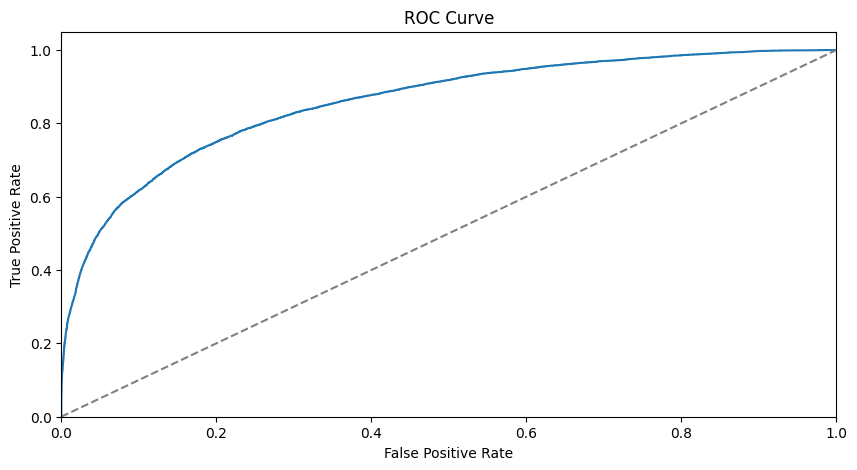

0.8567009361583336

In [ ]:
y_prob = optimal_rf.predict_proba(X)[:, 1]

fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = roc_auc_score(y, y_prob)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

roc_auc

##Part3- Weakest Feature

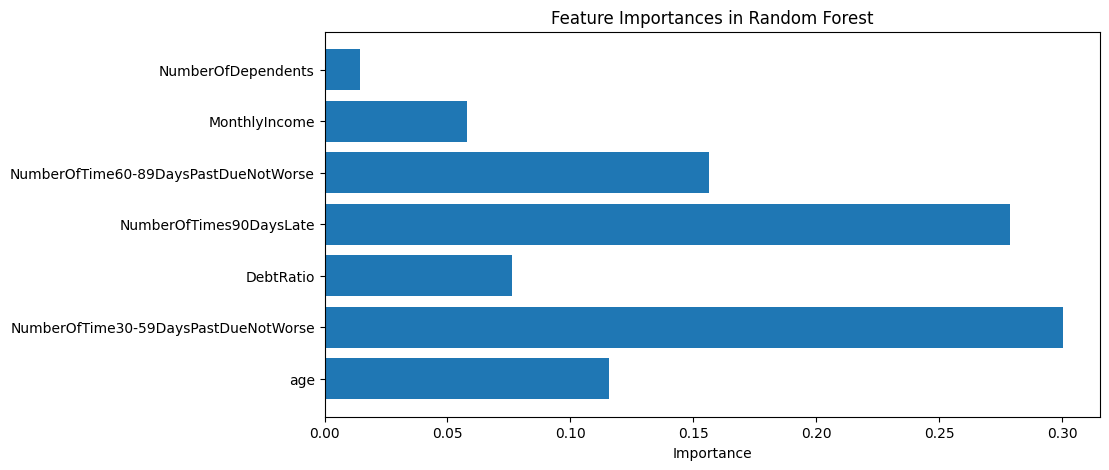

In [ ]:
feature_importances = optimal_rf.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest')
plt.show()

##Part4-Bagging

In [18]:
parameters = {
    'max_features': [2, 3, 4],
    'max_samples': [0.5, 0.7, 0.9],
    'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]
}

base_estimator = LogisticRegression(class_weight='balanced')
bagging = BaggingClassifier(base_estimator=base_estimator, n_estimators=100)

random_search = RandomizedSearchCV(
    estimator=bagging,
    param_distributions=parameters,
    n_iter=20,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1,
)

In [19]:
random_search.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced'),
                                               n_estimators=100),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'base_estimator__C': [0.0001, 0.001,
                                                              0.01, 1, 10,
                                                              100],
                                        'max_features': [2, 3, 4],
                                        'max_samples': [0.5, 0.7, 0.9]},
                   scoring='roc_auc')

In [20]:
best_paramemters_bagging = random_search.best_params_
best_paramemters_bagging

{'max_samples': 0.9, 'max_features': 2, 'base_estimator__C': 1}

In [27]:
best_score_bagging_roc_auc = random_search.best_score_
best_score_bagging_roc_auc

0.8061639555017092

In [ ]:
best_bagging = BaggingClassifier(
    estimator=LogisticRegression(C=100, solver='liblinear'),
    max_samples=0.5,
    max_features=2,
    n_estimators=100,
    random_state=42
)

best_bagging.fit(X, y)

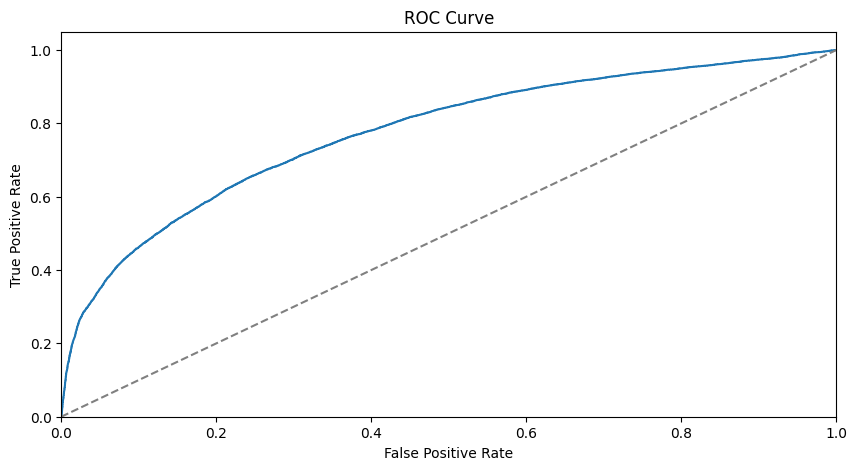

0.7743514975912642

In [ ]:
y_prob_bagging = best_bagging.predict_proba(X)[:, 1]

fpr_bagging, tpr_bagging, thresholds_bagging = roc_curve(y, y_prob_bagging)
roc_auc_bagging = roc_auc_score(y, y_prob_bagging)
plt.figure(figsize=(10, 5))
plt.plot(fpr_bagging, tpr_bagging)
plt.plot([0, 1], [0, 1], color='gray',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

roc_auc_bagging